<a href="https://colab.research.google.com/github/dunliangyang2010/Deep-Learning-practice/blob/master/Kaggle_vessel_segmentation_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image
import os
from glob import glob
from tqdm.auto import tqdm

import imgaug.augmenters as iaa
import imgaug as ia

from tensorflow.keras import *
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
# download dataset from https://drive.google.com/file/d/1JILW10sr40CRTLiuA1mf__5GBtMDF9xc/view?usp=sharing
!gdown --id 1JILW10sr40CRTLiuA1mf__5GBtMDF9xc --output vessel_seg.zip

# unzip file
!unzip -q vessel_seg.zip


Downloading...
From: https://drive.google.com/uc?id=1JILW10sr40CRTLiuA1mf__5GBtMDF9xc
To: /content/vessel_seg.zip
100% 29.2M/29.2M [00:00<00:00, 44.0MB/s]


# Data Analysis

In [3]:
# read img and mask
img_paths = glob('all/train/*.tif')
img_path = np.random.choice(img_paths, size=1)[0]
mask_path = img_path.replace('_training.tif', '_manual1.gif')

print('img path: ', img_path)
print('mask path:',  mask_path)

img = cv2.imread(img_path)[:, :, ::-1] # BGR -> RGB
mask = Image.open(mask_path)
mask = np.array(mask)

img.shape, mask.shape

img path:  all/train/28_training.tif
mask path: all/train/28_manual1.gif


((584, 565, 3), (584, 565))

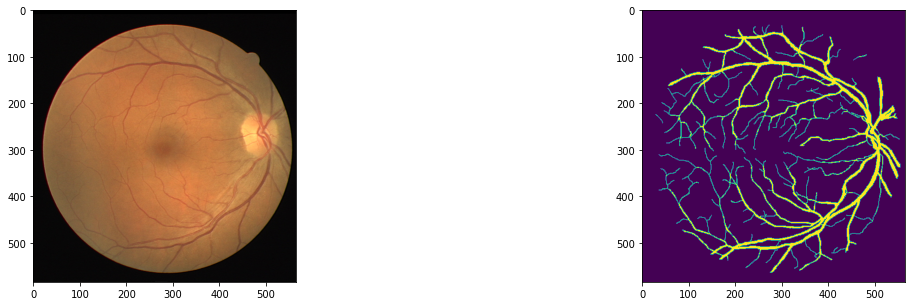

In [6]:
# show image
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1) # (row, column, #)
plt.imshow(img)
plt.subplot(1,2,2)
# plt.imshow(mask, cmap='gray')
plt.imshow(mask)
plt.show()

In [7]:
img.shape, mask.shape

((584, 565, 3), (584, 565))

#Data Processing

In [8]:
IMG_SIZE = 512
BS = 4 # batch size

In [9]:
class DataGenerator(utils.Sequence):
    def __init__(self, img_paths, batch_size, img_size, shuffle=True, mode='train', aug=False):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.img_size = img_size
        self.mode = mode
        self.img_paths = img_paths
        self.mask_paths = [p.replace('_training.tif', '_manual1.gif') for p in self.img_paths]
        self.aug = aug
        self.indexes = np.arange(len(self.mask_paths))
        self.seq = iaa.Sequential([
            iaa.Fliplr(0.5), # 50% horizontal flip
            iaa.Flipud(0.5),
            iaa.Affine(
                rotate=(90, -90), # random rotate -45 ~ +45 degree
                shear=(-3,3), # random shear -3 ~ +3 degree
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)} # scale x, y: 80%~120%
            ),
        ])
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.mask_paths) / self.batch_size)) # batches per epoch

    def __getitem__(self, batch_index):
        # Generate indexes of the batch
        idxs = self.indexes[batch_index * self.batch_size:(batch_index + 1) * self.batch_size]
        # Find list of IDs
        batch_img_paths = [self.img_paths[i] for i in idxs]
        batch_mask_paths = [self.mask_paths[i] for i in idxs]

        # Generate data
        X, y = self.__data_generation(batch_img_paths, batch_mask_paths)
        if self.mode != 'test':
            return X, y
        else:
            return X

    def on_epoch_end(self):
        # Updates indexes after each epoch
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, img_paths, mask_paths):
        # Generates data containing batch_size samples
        x = np.empty((len(img_paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.empty((len(img_paths), self.img_size, self.img_size, 1), dtype=np.float32)

        for i, (img_path, mask_path) in enumerate(zip(img_paths, mask_paths)):
            img = cv2.imread(img_path)[:, :, ::-1]
            img = self.preprocess(img) # 0~255 -> 0~1
            x[i] = img
            if self.mode != 'test':
                mask = np.array(Image.open(mask_path))
                mask = self.preprocess(mask) # 0 or 1
                y[i] = np.expand_dims(mask, axis=-1) # (512, 512) -> (512, 512, 1)
        # Augmentation
        if self.aug:
            x, y = self.seq(images=x, heatmaps=y)
        return x, y

    def preprocess(self, img):
        data = cv2.resize(img, (self.img_size, self.img_size))
        data = data / 255. # normalize to 0~1
        return data

In [10]:
all_paths = glob('all/train/*.tif')
test_paths = sorted(glob('all/test/*.tif'))
train_paths, val_paths = train_test_split(all_paths, test_size=0.2)

train_gen = DataGenerator(train_paths, BS, IMG_SIZE, shuffle=True, mode='train', aug=True)
val_gen = DataGenerator(val_paths, BS, IMG_SIZE, shuffle=False, mode='val')
test_gen = DataGenerator(test_paths, BS, IMG_SIZE, shuffle=False, mode='test')

(4, 512, 512, 3) (4, 512, 512, 1)


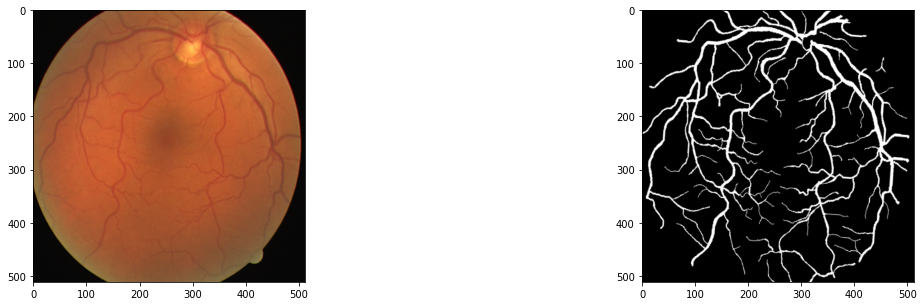

In [11]:
# Check output

batch_x, batch_y = train_gen[0]
print(batch_x.shape, batch_y.shape)

batch_i = np.random.choice(len(batch_x))
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.imshow(batch_x[batch_i])
plt.subplot(1,2,2)
plt.imshow(batch_y[batch_i, :, :, 0], cmap='gray') # (512, 512)
plt.show()

# Build model: U-Net

In [12]:
def conv_bn(x, filters):
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = conv_bn(input_layer, 8)
c1 = conv_bn(x, 8)
x = layers.MaxPool2D(strides=(2,2))(c1)
x = conv_bn(x, 16)
c2 = conv_bn(x, 16)
x = layers.MaxPool2D(strides=(2,2))(c2)
x = conv_bn(x, 32)
c3 = conv_bn(x, 32)
x = layers.MaxPool2D(strides=(2,2))(c3)
x = conv_bn(x, 64)
c4 = conv_bn(x, 64)

x = layers.concatenate([#layers.UpSampling2D(size=(2,2))(c4),
            layers.Conv2DTranspose(32, 3, strides=2, padding='same')(c4),
            c3], axis=-1)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = layers.concatenate([#layers.UpSampling2D(size=(2,2))(x), 
            layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x),
            c2], axis=-1)
x = conv_bn(x, 64)
x = conv_bn(x, 64)
x = layers.concatenate([#layers.UpSampling2D(size=(2,2))(x), 
            layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x),
            c1], axis=-1)
x = conv_bn(x, 128)
x = conv_bn(x, 128)

# 最後一層是segmentation結果，只分前景後景->二元分類,可用sigmoid loss可用binary loss
output_layer = layers.Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(x)
                                                         
model = models.Model(input_layer, output_layer)

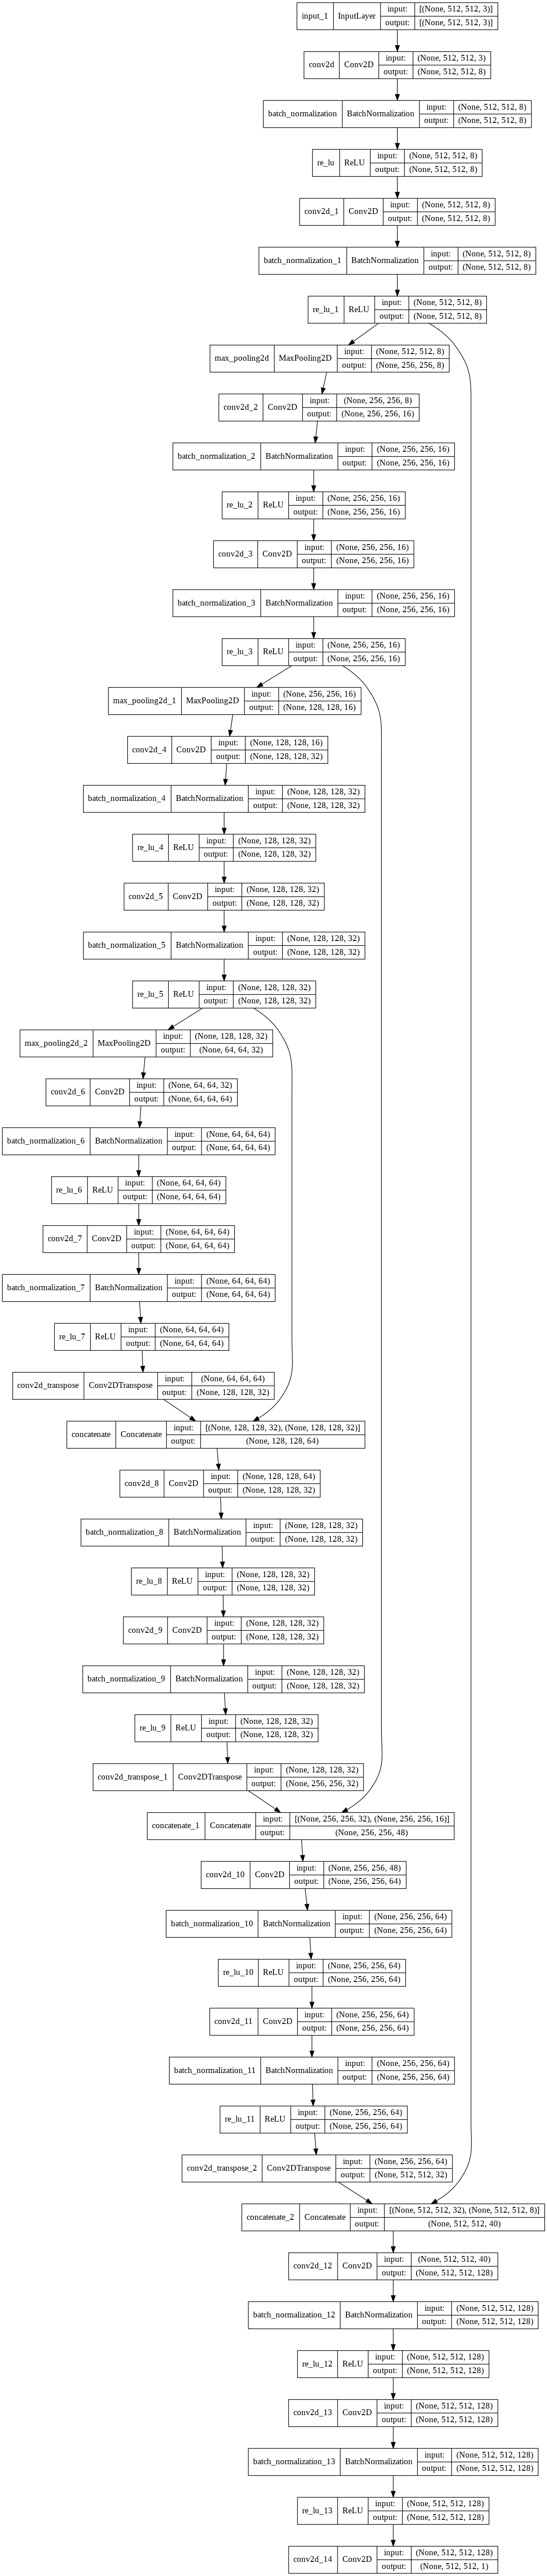

In [13]:
utils.plot_model(model, show_shapes=True)

# Training

In [15]:
# Customize Dice coefficient
# K = tf.keras.backend

# range: 0 ~ 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon()) # 1e-6, 1e-7 避免分母為0
0
# range: 1 ~ 0
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [19]:
model.compile(optimizer=optimizers.Adam(), 
        loss='binary_crossentropy', 
        metrics=[dice_coef],
        #loss=dice_loss,
        )

In [20]:
weight_saver = callbacks.ModelCheckpoint('seg.h5', 
                      save_best_only=True)
earlystop = callbacks.EarlyStopping(patience=10) # patience=100

In [21]:
logs = model.fit(train_gen,
          validation_data = val_gen,
          epochs=500, 
          #epoch = 1000
          callbacks = [weight_saver, earlystop])

Epoch 1/500
4/4 [==============================] - 27s 2s/step - loss: 0.4551 - dice_coef: 0.1594 - val_loss: 0.6554 - val_dice_coef: 0.1438
Epoch 2/500
4/4 [==============================] - 6s 1s/step - loss: 0.2844 - dice_coef: 0.1955 - val_loss: 0.6324 - val_dice_coef: 0.1429
Epoch 3/500
4/4 [==============================] - 6s 1s/step - loss: 0.2379 - dice_coef: 0.2164 - val_loss: 0.6006 - val_dice_coef: 0.1409
Epoch 4/500
4/4 [==============================] - 6s 1s/step - loss: 0.2107 - dice_coef: 0.2820 - val_loss: 0.5690 - val_dice_coef: 0.1395
Epoch 5/500
4/4 [==============================] - 6s 1s/step - loss: 0.1935 - dice_coef: 0.3313 - val_loss: 0.5444 - val_dice_coef: 0.1386
Epoch 6/500
4/4 [==============================] - 6s 1s/step - loss: 0.1821 - dice_coef: 0.3545 - val_loss: 0.5320 - val_dice_coef: 0.1382
Epoch 7/500
4/4 [==============================] - 6s 1s/step - loss: 0.1900 - dice_coef: 0.3891 - val_loss: 0.5087 - val_dice_coef: 0.1380
Epoch 8/500
4/4 [==

# Evaluate

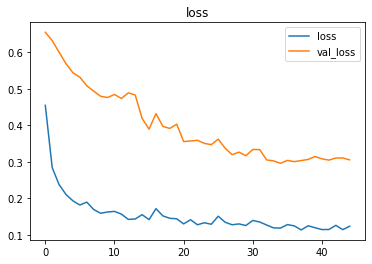

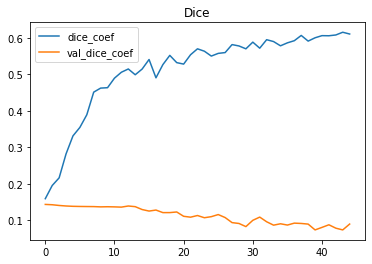

In [24]:
history = logs.history
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title('loss')
plt.show()
plt.plot(history['dice_coef'])
plt.plot(history['val_dice_coef'])
plt.legend(['dice_coef','val_dice_coef'])
plt.title('Dice')
plt.show()

In [25]:
model_final = models.load_model('seg.h5', compile=False)

0


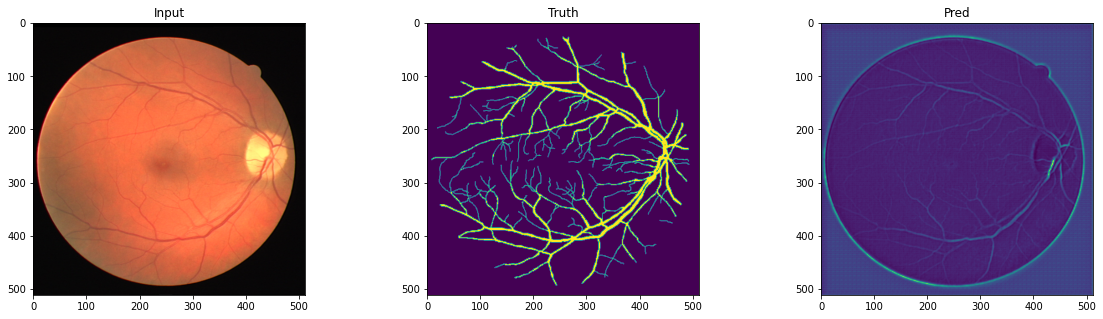

In [26]:
# Sample 1 batch
batch_idx = np.random.randint(len(val_gen))
print(batch_idx)
data = val_gen[batch_idx]
imgs, mask = data # (bs, 512, 512, 3), (bs, 512, 512, 1)
mask_pred = model_final.predict(imgs)

# show inputs
img_idx = np.random.randint(len(imgs)) # sample 1 image from batch (4張裡隨機1張)
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.imshow(imgs[img_idx])
plt.title('Input')

# show ground truth & model prediction
plt.subplot(1, 3, 2)
plt.imshow(mask[img_idx, :, :, 0])
plt.title('Truth')
plt.subplot(1, 3, 3)
plt.imshow(mask_pred[img_idx, :, :, 0])
plt.title('Pred')
plt.show()
# plt.imshow(mask_pred[img_idx, :, :, 0], cmap='gray')

In [27]:
# Displayed with different threshold
mask_pred_raw = mask_pred[img_idx, :, :, 0]
mask_pred_raw

array([[0.1310173 , 0.16336177, 0.13745509, ..., 0.19343278, 0.16177903,
        0.19249348],
       [0.13589184, 0.1927441 , 0.14396706, ..., 0.21743943, 0.17505395,
        0.20698735],
       [0.12770009, 0.14802317, 0.11895876, ..., 0.18063526, 0.15605716,
        0.20466195],
       ...,
       [0.12178263, 0.14694609, 0.09721123, ..., 0.13752346, 0.14607339,
        0.159721  ],
       [0.12197904, 0.12791847, 0.12378088, ..., 0.12208324, 0.1461778 ,
        0.14966443],
       [0.12317075, 0.1720951 , 0.13672791, ..., 0.1541316 , 0.14472991,
        0.16707036]], dtype=float32)

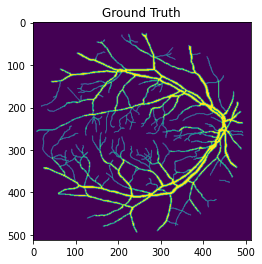

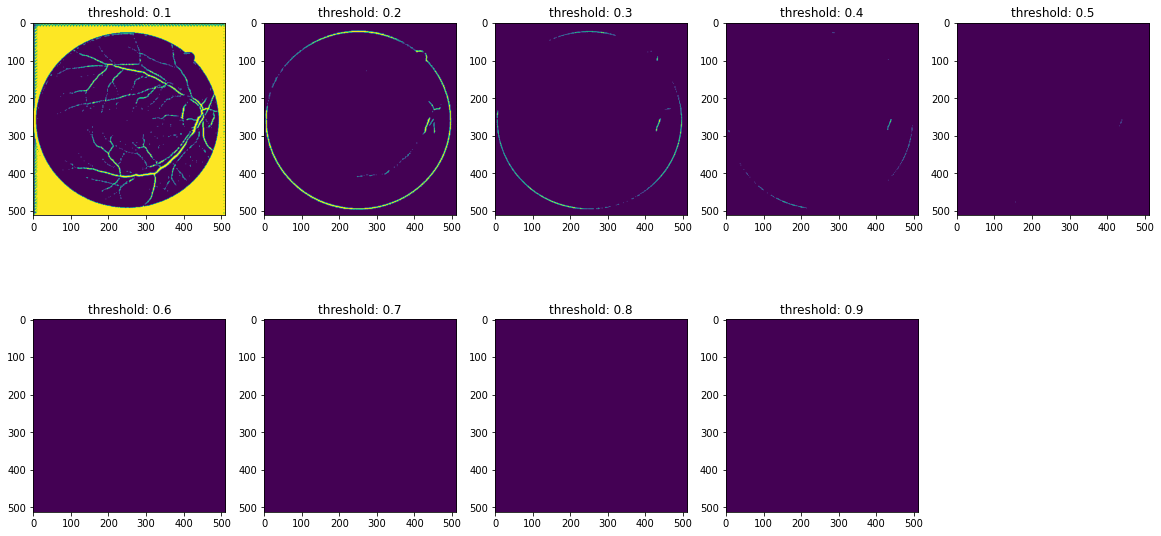

In [28]:
plt.imshow(mask[img_idx, :, :, 0])
plt.title('Ground Truth')
plt.show()

plt.figure(figsize=(20, 10))
for i in range(1, 10):
    plt.subplot(2, 5, i)
    threshold = i * 0.1
    mask_threshold = mask_pred_raw.copy()
    mask_threshold[mask_threshold <= threshold] = 0.
    mask_threshold[mask_threshold > threshold] = 1.
    plt.imshow(mask_threshold)
    plt.title(f'threshold: {threshold:.1f}')
plt.show()

# Make Kaggle prediction
https://www.kaggle.com/c/sai-vessel-segmentation/leaderboard

In [29]:
# make prediction
threshold = 0.5
outputs = []
for i in range(len(test_gen)):
    x_test = test_gen[i]
    y_preds = model_final.predict(x_test)
    y_preds[y_preds <= threshold] = 0
    y_preds[y_preds > threshold] = 1
    for y_pred in y_preds:
        dots = np.where(y_pred.flatten() == 1)[0]
        run_lengths = []
        prev = -2
        for b in dots:
            if (b > prev +1):
                run_lengths.extend((b+1,0))
            run_lengths[-1] += 1
            prev = b
        output = ' '.join([str(r) for r in run_lengths])
        outputs.append(output)

In [30]:
df = pd.DataFrame(columns=['Id', 'Predicted'])
df['Id'] = [str(i) for i in range(20)]
df['Predicted'] = outputs
df.to_csv('submission.csv', index=None)
df

,Id,Predicted
0,0,
1,1,225886 1 226912 1 236154 1 240264 1 241292 1 2...
2,2,
3,3,130362 1 131385 1 131897 1 132408 2 132920 1 1...
4,4,
5,5,159246 1 163344 1 163856 1 164368 2 164881 1 1...
6,6,
7,7,210496 1
8,8,51126 1 51638 1 52150 1 163822 1 178149 1 1934...
9,9,
